In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from pymoo.core.problem import ElementwiseProblem
from sklearn.svm import SVR
import pyswarms as ps
from SwarmPackagePy import testFunctions as tf
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout, Flatten
from keras.layers import Flatten

In [2]:
pip install pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 25.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for grapheme: filename=grapheme-0.6.0-py3-none-any.whl size=210078 sha256=7862d92467de5aabb39a5eee89351c79280d622e6f859701ceb5be8e380d36cc
  Stored in directory: /root/.cache/pip/wheels/01/e1/49/37e6bde9886439057450c494a79b0bef8bbe897a54aebfc757
Successfully built grapheme


In [3]:
!pip install pyswarms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 3.7 MB/s eta 0:00:00


In [4]:
!pip install SwarmPackagePy

  Preparing metadata (setup.py) ... done
  Created wheel for SwarmPackagePy: filename=SwarmPackagePy-1.0.0a5-py3-none-any.whl size=21160 sha256=a31047f8e01ff209d9b18dbf817039dd35a8194be054a3fea64c7e89a741a03b
  Stored in directory: /root/.cache/pip/wheels/7b/a1/da/a4705dd3dc62b3e4e4b614c96f399d3a0ffa3cb04105813527
Successfully built SwarmPackagePy


In [38]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculateMetrics(algorithm, predict, test_labels):
    global scaler1
    mse_error = mean_squared_error(test_labels, predict)
    square_error = 1 - mse_error
    mse_error = mean_squared_error(test_labels, predict)
    rmse = np.sqrt(mse_error)
    nrmse = rmse / (test_labels.max() - test_labels.min())
    mae = mean_absolute_error(test_labels, predict)
    mad = np.mean(np.abs(test_labels - predict))
    vaf = 1 - (np.var(test_labels - predict) / np.var(test_labels))
    predict = predict.reshape(-1, 1)
    predict = scaler1.inverse_transform(predict)
    test_label = scaler1.inverse_transform(test_labels)
    predict = predict.ravel()
    test_label = test_label.ravel()
    print("MSE:",str(mse_error))
    print("R2:",str(square_error))
    print("RMSE:", rmse)
    print("NRMSE:", nrmse)
    print("MAE:", mae)
    print("MAD:", mad)
    print("VAF:", vaf)

    print()
    for i in range(0, 10):
        print("True Flyrock Distance:", str(test_label[i]),"Predicted Flyrock Distance",str(predict[i]))
    plt.figure(figsize=(5,3))
    plt.plot(test_label, color = 'red', label = 'True Flyrock Distance')
    plt.plot(predict, color = 'green', label = 'Predicted Flyrock Distance')
    plt.title(algorithm+' Flyrock Distance Prediction Graph')
    plt.xlabel('Test Data')
    plt.ylabel('Prediction')
    plt.legend()
    plt.show()

In [6]:
dataset=pd.read_csv("/content/Dataset.csv")

In [7]:

scaler = MinMaxScaler(feature_range = (0, 1))
scaler1 = MinMaxScaler(feature_range = (0, 1))
dataset.fillna(0, inplace=True)
dataset = dataset.values
X = dataset[2:dataset.shape[0],1:dataset.shape[1]-1]
X = scaler.fit_transform(X)
Y = dataset[2:dataset.shape[0]:,dataset.shape[1]-1]
print("Processed & Normalized Features = ",str(X))

Processed & Normalized Features =  [[0.         0.         0.05555556 0.19354839 0.         0.14492754]
 [0.         0.05263158 0.01851852 0.19354839 0.00970518 0.07246377]
 [0.         0.05263158 0.01851852 0.         0.00970518 0.        ]
 ...
 [1.         0.94736842 0.77777778 0.90322581 0.96117927 0.62318841]
 [1.         0.94736842 1.         0.80645161 0.96117927 0.53623188]
 [1.         0.94736842 0.96296296 0.83870968 0.96117927 0.97101449]]


In [8]:
print(X)

[[0.         0.         0.05555556 0.19354839 0.         0.14492754]
 [0.         0.05263158 0.01851852 0.19354839 0.00970518 0.07246377]
 [0.         0.05263158 0.01851852 0.         0.00970518 0.        ]
 ...
 [1.         0.94736842 0.77777778 0.90322581 0.96117927 0.62318841]
 [1.         0.94736842 1.         0.80645161 0.96117927 0.53623188]
 [1.         0.94736842 0.96296296 0.83870968 0.96117927 0.97101449]]


In [14]:
class MOO(ElementwiseProblem):
    def __init__(self, features, target):
        super().__init__(n_var=features.shape[1], n_obj=1)
        self.features = features
        self.target = target

    def _evaluate(self, x):
        y = np.dot(x, self.features)
        return np.sum((y - self.target)**2)

In [15]:
def f_per_particle(m, alpha):
    global X, Y, svm_cls
    total_features = X.shape[1]
    if np.count_nonzero(m) == 0:
        X_subset = X
    else:
        X_subset = X[:,m==1]
    svm_cls.fit(X_subset, Y)
    P = (svm_cls.predict(X_subset) == Y).mean()
    j = (alpha * (1.0 - P) + (1.0 - alpha) * (1 - (X_subset.shape[1] / total_features)))
    return j

In [16]:
def f(x, alpha=0.88):
    n_particles = x.shape[0]
    j = [f_per_particle(x[i], alpha) for i in range(n_particles)]
    return np.array(j)

In [17]:
def runPSO():
    global X, Y, pso, svm_cls, scaler1
    svm_cls = SVR()
    print("Total features found in dataset before applying MOO Optimization & PSO Features Selection : ",str(X.shape[1]))
    moo = MOO(X, Y)
    X = moo.features
    options = {'c1': 0.9, 'c2': 0.9, 'w':0.5, 'k': 5, 'p':2}
    dimensions = X.shape[1]
    optimizer = ps.discrete.BinaryPSO(n_particles=5, dimensions=dimensions, options=options)
    cost, pso = optimizer.optimize(f, iters=10)
    X = X[:,pso==1]
    Y = Y.reshape(-1,1)
    Y = scaler1.fit_transform(Y)
    print("Total features found in dataset after applying MOO Optimization & PSO Features Selection : ",str(X.shape[1]))

In [39]:
def runHybrdiANN():
    global X, Y
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2)
    #now train & plot ANN Crop Yield prediction graph
    ann_model = Sequential()
    # Adding the first hidden layer with 50 neurons
    ann_model.add(Dense(50, input_shape=(X_train.shape[1],)))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))

    # Adding the second hidden layer with 50 neurons
    ann_model.add(Dense(50))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))

    # Adding more hidden layers
    ann_model.add(Dense(50))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))

    ann_model.add(Dense(50))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))

    ann_model.add(Dense(50))
    ann_model.add(Activation('relu'))
    ann_model.add(Dropout(0.2))

    # Adding the output layer
    ann_model.add(Dense(1))

    ann_model.compile(optimizer='adam', loss='mean_squared_error')
    ann_model.fit(X, Y, batch_size = 16, epochs = 50, validation_data=(X_test, y_test), verbose=2)
    predict = ann_model.predict(X_test)
    calculateMetrics("Hybrid Model", predict, y_test)#call function to plot LSTM crop yield prediction

In [20]:
runPSO()

2024-05-15 16:28:32,240 - pyswarms.discrete.binary - INFO - Optimize for 10 iters with {'c1': 0.9, 'c2': 0.9, 'w': 0.5, 'k': 5, 'p': 2}


Total features found in dataset before applying MOO Optimization & PSO Features Selection :  6


pyswarms.discrete.binary: 100%|██████████|10/10, best_cost=0.9
2024-05-15 16:28:32,482 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.9, best pos: [1 1 0 1 1 1]


Total features found in dataset after applying MOO Optimization & PSO Features Selection :  5


Epoch 1/50
17/17 - 2s - loss: 0.1434 - val_loss: 0.0213 - 2s/epoch - 111ms/step
Epoch 2/50
17/17 - 0s - loss: 0.0470 - val_loss: 0.0442 - 100ms/epoch - 6ms/step
Epoch 3/50
17/17 - 0s - loss: 0.0333 - val_loss: 0.0187 - 86ms/epoch - 5ms/step
Epoch 4/50
17/17 - 0s - loss: 0.0336 - val_loss: 0.0353 - 97ms/epoch - 6ms/step
Epoch 5/50
17/17 - 0s - loss: 0.0287 - val_loss: 0.0199 - 104ms/epoch - 6ms/step
Epoch 6/50
17/17 - 0s - loss: 0.0279 - val_loss: 0.0368 - 88ms/epoch - 5ms/step
Epoch 7/50
17/17 - 0s - loss: 0.0256 - val_loss: 0.0227 - 86ms/epoch - 5ms/step
Epoch 8/50
17/17 - 0s - loss: 0.0260 - val_loss: 0.0313 - 97ms/epoch - 6ms/step
Epoch 9/50
17/17 - 0s - loss: 0.0237 - val_loss: 0.0321 - 83ms/epoch - 5ms/step
Epoch 10/50
17/17 - 0s - loss: 0.0228 - val_loss: 0.0230 - 86ms/epoch - 5ms/step
Epoch 11/50
17/17 - 0s - loss: 0.0218 - val_loss: 0.0228 - 102ms/epoch - 6ms/step
Epoch 12/50
17/17 - 0s - loss: 0.0235 - val_loss: 0.0397 - 104ms/epoch - 6ms/step
Epoch 13/50
17/17 - 0s - loss: 0.

2024-05-15 16:43:13,598 - tensorflow - WARNING - 6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7e857f513490> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 [==============================] - 0s 13ms/step
MSE: 0.029734480978972952
R2: 0.9702655190210271
RMSE: 0.17243688984371341
NRMSE: 0.1860503285155855
MAE: 0.13745184423448384
MAD: 0.13745184423448384
VAF: 0.6976824163254001

True Flyrock Distance: 0.27177700348432055 Predicted Flyrock Distance 0.2743122
True Flyrock Distance: 0.43554006968641124 Predicted Flyrock Distance 0.344736
True Flyrock Distance: 0.6027874564459931 Predicted Flyrock Distance 0.5036086
True Flyrock Distance: 0.5121951219512195 Predicted Flyrock Distance 0.35262814
True Flyrock Distance: 0.46341463414634154 Predicted Flyrock Distance 0.36692935
True Flyrock Distance: 0.2752613240418119 Predicted Flyrock Distance 0.30159128
True Flyrock Distance: 0.6724738675958188 Predicted Flyrock Distance 0.44922465
True Flyrock Distance: 0.33797909407665505 Predicted Flyrock Distance 0.29223752
True Flyrock Distance: 0.7038327526132404 Predicted Flyrock Distance 0.56491745
True Flyrock Distance: 0.613240418118467 Predicted F

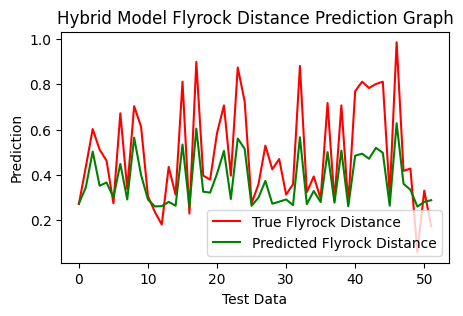

In [40]:
runHybrdiANN()